In [2]:
from __future__ import print_function
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.distributions as tdist
from ignite.metrics import InceptionScore

In [4]:

DIM = 20
device = 'cpu'

# all classes below are altered from the TA's sheet3_solution.ipynb file. 
# thus, the basic structure of the classes are the same.

class VAE(nn.Module):
    def __init__(self, hidden_dims=[500, 500, DIM, 500, 500], data_dim=784):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor):
        h1 = F.dropout(F.relu(self.in_layer(x)), p=0.1)
        h2 = F.dropout(F.relu(self.enc_h(h1)), p=0.1)
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.dropout(F.relu(self.dec_h(z)), p=0.1)
        h4 = F.dropout(F.relu(self.dec_layer(h3)), p=0.1)
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class CBVAE(nn.Module):
    def __init__(self, hidden_dims=[500, 500, DIM, 500, 500], data_dim=784):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor):
        h1 = F.dropout(F.relu(self.in_layer(x)), p=0.1)
        h2 = F.dropout(F.relu(self.enc_h(h1)), p=0.1)
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.dropout(F.relu(self.dec_h(z)), p=0.1)
        h4 = F.dropout(F.relu(self.dec_layer(h3)), p=0.1)
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class BetaDistVAE(nn.Module):
    def __init__(self, hidden_dims=[500, 500, DIM, 500, 500], data_dim=784):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        
        # self.beta_reg = nn.Parameter(torch.ones(1))
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], 2*data_dim)
        # self.out_layer_alpha = nn.Linear(hidden_dims[-1], data_dim)
        # self.out_layer_beta = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor):
        h1 = F.dropout(F.relu(self.in_layer(x)), p=0.1)
        h2 = F.dropout(F.relu(self.enc_h(h1)), p=0.1)
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.dropout(F.relu(self.dec_h(z)), p=0.1)
        h4 = F.dropout(F.relu(self.dec_layer(h3)), p=0.1)
        # ALTERED
        beta_params = self.out_layer(h4)
        alphas = 1e-6 + F.softplus(beta_params[:, :self.data_dim])
        betas = 1e-6 + F.softplus(beta_params[:, self.data_dim:])
        return alphas, betas

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        alphas, betas = self.decode(z)
        return alphas, betas, mu, logvar


In [5]:
vae_model = torch.load('trained_models/vae_100_2.pt')
cbvae_model = torch.load('trained_models/cbvae_100.pt')
beta_vae_model = torch.load('trained_models/betavae_100.pt')
beta_vae_model_s = torch.load('trained_models/betavae_100_s.pt')

In [6]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)

with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = vae_model(data)
        recon_batch_cbvae, mu_cbvae, logvar_cbvae = cbvae_model(data)
        # z, alphas, betas, mu_betavae, logvar_betavae = betavae_model(data)
        break

n = 8

recon_batch = recon_batch.view(128, 1, 28, 28)
recon_batch_cbvae = recon_batch_cbvae.view(128, 1, 28, 28)
comparison = torch.cat([data[:n], recon_batch[:n], recon_batch_cbvae[:n]])

save_image(comparison.cpu(),
                           'figs/reconstruction_comparison_b_cb.png', nrow=n)

# plt.figure(figsize=(10, 4))
# for i in range(1, 3*n+1):
#     ax = plt.subplot(4,n,i)
#     plt.imshow(comparison.cpu().detach().numpy()[i-1, 0,:,:], cmap="gray")
#     plt.axis('off')

# plt.savefig('figs/reconstruction_comparison_b_cb.png')
# plt.close()


In [7]:
with torch.no_grad():
        sample = vae_model.decode(torch.randn(64, 2))
        cbsample = cbvae_model.decode(torch.randn(64, 20))
comparison = torch.cat([sample[:2*n], cbsample[:2*n]])
save_image(comparison.view(-1, 1, 28, 28),
                'figs/sample_comparison_b_cb.png')

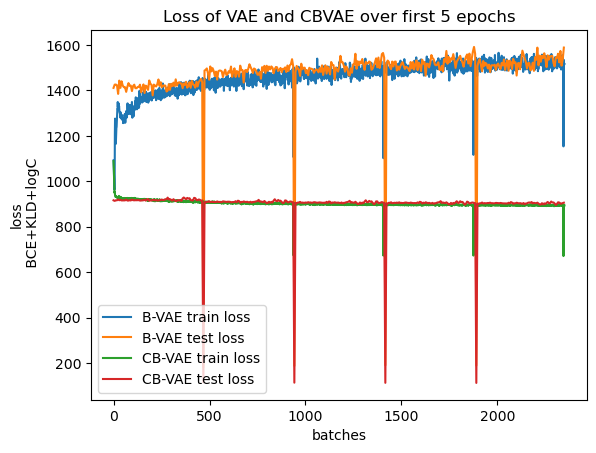

In [8]:
EPOCHS = 5

cbvae_train_loss = np.load("tmp/cbvae_train_loss_vals_total_100.npy")
cbvae_test_loss = np.load("tmp/cbvae_test_loss_vals_total_100.npy")
vae_train_loss = np.load("tmp/vae_train_loss_vals_total_100_2.npy")
vae_test_loss = np.load("tmp/vae_test_loss_vals_total_100_2.npy")

plt.plot(np.arange(EPOCHS*470), vae_train_loss[:EPOCHS*470], label="B-VAE train loss")
plt.plot(np.arange(0, EPOCHS*470, 6), vae_test_loss[:int(EPOCHS*78.4)], label="B-VAE test loss")
plt.plot(np.arange(EPOCHS*470), cbvae_train_loss[:EPOCHS*470], label="CB-VAE train loss")
plt.plot(np.arange(0, EPOCHS*470, 6), cbvae_test_loss[:int(EPOCHS*78.4)], label="CB-VAE test loss")

plt.xlabel("batches")
plt.ylabel("loss\n BCE+KLD+logC")
plt.title("Loss of VAE and CBVAE over first 5 epochs")
plt.legend()
plt.show()


(array([2.59773238e-03, 1.54335865e-02, 3.25480587e-02, 3.78352081e-02,
        4.31223575e-02, 3.86909317e-02, 3.27619896e-02, 2.67719243e-02,
        2.13625286e-02, 1.75423340e-02, 1.18884458e-02, 7.94600493e-03,
        5.92894214e-03, 4.03412558e-03, 2.56717082e-03, 1.89481656e-03,
        1.00853140e-03, 5.50108034e-04, 4.27861804e-04, 3.05615574e-04,
        1.22246230e-04, 1.22246230e-04, 3.05615574e-05, 0.00000000e+00,
        6.11231149e-05, 3.05615574e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.05615574e-05]),
 array([875.34106445, 878.61314901, 881.88523356, 885.15731812,
        888.42940267, 891.70148722, 894.97357178, 898.24565633,
        901.51774089, 904.78982544, 908.06190999, 911.33399455,
        914.6060791 , 917.87816366, 921.15024821, 924.42233276,
        927.69441732, 930.96650187, 934.23858643, 937.51067098,
        940.78275553, 944.05484009, 947.32692464, 950.5990092 ,
        953.87109375, 957.1431783 , 960.41526286, 963.68734741,
      

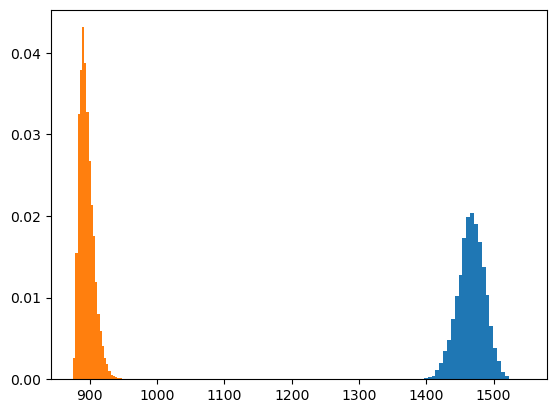

In [7]:

def sumlogC(x, eps=1e-5):
    x = torch.clamp(x, eps, 1.-eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values = torch.log(
        (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far))
    close_values = torch.log(torch.tensor((2.))) + \
        torch.log(1. + torch.pow(1. - 2. * close, 2)/3.)
    return far_values.sum() + close_values.sum()


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    logC = sumlogC(recon_x)
    return sum([BCE, KLD, logC])

datapoints = []
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        datapoints.append(data[0])
        # break

repetitions = 10000

datapoint = datapoints[2]
datapoint = datapoint.view(-1, 784)
vae_mu, vae_logvar = vae_model.encode(datapoint)
cbvae_mu, cbvae_logvar = cbvae_model.encode(datapoint)
# betavae_mu, betavae_logvar = beta_vae_model.encode(datapoint)

vae_sampling = tdist.MultivariateNormal(vae_mu, (1.e-7+torch.exp(0.5*vae_logvar))*torch.eye(2))
vae_samples = vae_sampling.sample((repetitions,))
cbvae_sampling = tdist.MultivariateNormal(cbvae_mu, (1.e-7+torch.exp(0.5*cbvae_logvar))*torch.eye(20))
cbvae_samples = cbvae_sampling.sample((repetitions,))
# betavae_sampling = tdist.MultivariateNormal(betavae_mu, (1.e-6+torch.exp(0.5*betavae_logvar))*torch.eye(20))
# betavae_samples = betavae_sampling.sample((repetitions,))

vae_recon = vae_model.decode(vae_samples)
cbvae_recon = cbvae_model.decode(cbvae_samples)
# betavae_alphas, betavae_betas = beta_vae_model.decode(betavae_samples)
# betavae_recon = betavae_alphas / (betavae_alphas + betavae_betas)

# save_image(vae_recon.view(repetitions, 1, 28, 28), 'figs/vae_recon.png')
# save_image(cbvae_recon.view(repetitions, 1, 28, 28), 'figs/cbvae_recon.png')
# save_image(betavae_recon.view(repetitions, 1, 28, 28), 'figs/betavae_recon.png')

vae_losses = []
cbvae_losses = []
betavae_losses = []
for i in range(repetitions):
    vae_losses.append(loss_function(vae_recon[i], datapoint, vae_mu, vae_logvar).item())
    cbvae_losses.append(loss_function(cbvae_recon[i], datapoint, cbvae_mu, cbvae_logvar).item())
    # betavae_losses.append(loss_function(betavae_recon[i], datapoint, betavae_mu, betavae_logvar).item())

B-VAE mean loss:  1466.744414453125
CB-VAE mean loss:  895.3331666992187


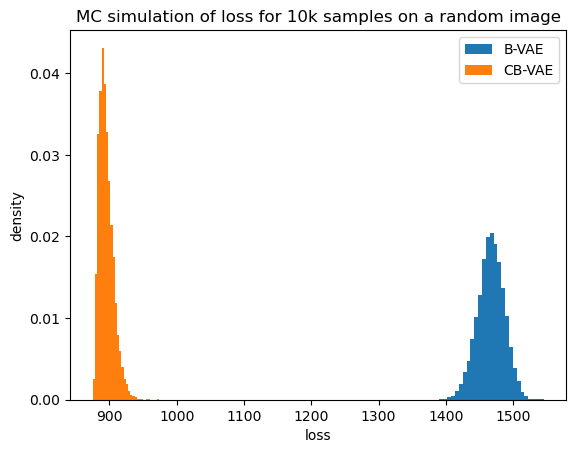

In [12]:
plt.figure()
plt.hist(vae_losses, bins=30, density=True, label="B-VAE")
plt.hist(cbvae_losses, bins=30, density=True, label="CB-VAE")
plt.xlabel("loss")
plt.ylabel("density")
plt.title("MC simulation of loss for 10k samples on a random image")
plt.legend()
print("B-VAE mean loss: ", np.mean(vae_losses))
print("CB-VAE mean loss: ", np.mean(cbvae_losses))